In [2]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

STEP 1

In [3]:
###---- STEP 1---####

#Loading data and exploring shape and variables
messy_dataset_original = pd.read_csv('/Users/daivik/Downloads/messy_dataset.csv')

#Initial processing, finding rows and columns, exploring what null variables there are, etc. 
rows, columns = messy_dataset_original.shape
print(f"Rows: {rows}, Columns: {columns}")

print("\n")

missing_values = messy_dataset_original.isnull().sum()
print(f"Missing Values: \n{missing_values}")

print("\n")

#Examining if there are duplicate values
duplicates = messy_dataset_original.duplicated().sum()
print(f"Duplicates: {duplicates}")

#Looking at basic identity of the dataset 
messy_dataset_original.head()


Rows: 100, Columns: 8


Missing Values: 
CustomerID           0
Age                 12
State               15
Income              17
Purchases           16
LastPurchaseDate    21
Review              23
Churn               24
dtype: int64


Duplicates: 0


,CustomerID,Age,State,Income,Purchases,LastPurchaseDate,Review,Churn
0,CUST001,40.0,CA,40000.0,0.0,NaN,NaN,NaN
1,CUST002,40.0,california,40000.0,1.0,NaN,NaN,NaN
2,CUST003,60.0,NY,40000.0,10.0,2021-13-40,NaN,N
3,CUST004,200.0,California,1000000.0,10.0,2021-13-40,Great product!,Y
4,CUST005,200.0,CA,40000.0,NaN,5/20/2021,Loved it!!!,Yes


We can see from looking at the initial head of the dataset, there are lots of red flags. There are ages in the 200's, the majority of the columns are formatted differently. For example, state is written in all types of cases/abbreviations, there are null values, Dates are written differently. 

In [4]:
###---- STEP 2---####

# We already have missing values defined, so we can go more in depth into it
missing_values_percentage = missing_values / rows * 100
print(f"Percentage of Missing Values: \n{missing_values_percentage}")


Percentage of Missing Values: 
CustomerID           0.0
Age                 12.0
State               15.0
Income              17.0
Purchases           16.0
LastPurchaseDate    21.0
Review              23.0
Churn               24.0
dtype: float64


We can see there are some columns with a decent amount of missing values. I think the best quick solution is to take the mean to replace null values. With more time, we can think about filtering for specific criteria. 

In [5]:
#Fill all numeric columns null values with their mean
messy_dataset_original.fillna(messy_dataset_original.select_dtypes(include=['float64', 'int64']).mean())


,CustomerID,Age,State,Income,Purchases,LastPurchaseDate,Review,Churn
0,CUST001,40.0,CA,40000.0,0.000000,NaN,NaN,NaN
1,CUST002,40.0,california,40000.0,1.000000,NaN,NaN,NaN
2,CUST003,60.0,NY,40000.0,10.000000,2021-13-40,NaN,N
3,CUST004,200.0,California,1000000.0,10.000000,2021-13-40,Great product!,Y
4,CUST005,200.0,CA,40000.0,2.928571,5/20/2021,Loved it!!!,Yes
...,...,...,...,...,...,...,...,...
95,CUST096,30.0,California,70000.0,10.000000,2021-13-40,Ok,N
96,CUST097,25.0,CA,50000.0,2.928571,2021-13-40,would buy again,NaN
97,CUST098,25.0,NaN,1000000.0,1.000000,NaN,Great product!,N
98,CUST099,25.0,California,50000.0,3.000000,NaN,Great product!,Y


In [6]:
###--- Step 3---###
messy_dataset_original.Age.value_counts()

Age
 25.0     16
 45.0     15
 50.0     15
 200.0    10
 60.0      9
 40.0      7
 30.0      6
-5.0       5
 35.0      5
Name: count, dtype: int64

We can see the many wrong looking age values here. Since we dont know the stakeholders, I will just replace crazy values with the mean. 

In [7]:
messy_dataset_original['Age'] = messy_dataset_original['Age'].round()
age_mean = messy_dataset_original['Age'].mean()
messy_dataset_original['Age'] = messy_dataset_original['Age'].replace([200, -5], age_mean)
messy_dataset_original.Age.value_counts()


Age
25.000000    16
56.534091    15
45.000000    15
50.000000    15
60.000000     9
40.000000     7
30.000000     6
35.000000     5
Name: count, dtype: int64

In [8]:
messy_dataset_original.State.value_counts()

State
California    23
CA            15
california    14
newyork       12
New York      11
NY            10
Name: count, dtype: int64

Since we only have 2 states, I think it is fair to hard code the righ values for them

In [9]:
messy_dataset_original.State = messy_dataset_original.State.replace(['california', 'CA'], 'California')
messy_dataset_original.State = messy_dataset_original.State.replace(['NY', 'newyork'], 'New York')
messy_dataset_original.State.value_counts()

State
California    52
New York      33
Name: count, dtype: int64

I'll do the same for Churn

In [10]:
messy_dataset_original.Churn = messy_dataset_original.Churn.replace(['Y'], 'Yes')
messy_dataset_original.Churn = messy_dataset_original.Churn.replace(['N'], 'No')
messy_dataset_original.Churn.value_counts()

Churn
No     38
Yes    38
Name: count, dtype: int64

Step 4. Inspect Income

In [11]:
#Visualizing income distribution
messy_dataset_original.Income.value_counts()



Income
1000000.0    26
50000.0      17
40000.0      16
60000.0      14
70000.0      10
Name: count, dtype: int64

<Axes: xlabel='Income', ylabel='Count'>

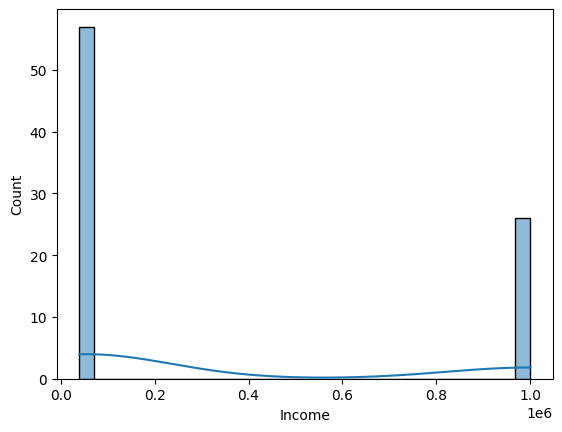

In [12]:
sns.histplot(messy_dataset_original['Income'], bins=30, kde=True)

We can see the data is very skewed with outliers. So many values at 1000000.0 could be a reg flag that they are incorrect, especially since we see the average range from 40000 to 70000. With little information, I think the safest bet is to normalize this to the average. 

In [13]:
income_mean_normalize = messy_dataset_original.loc[messy_dataset_original.Income !=1_000_000.0, 'Income'].mean()
messy_dataset_original.Income = messy_dataset_original.Income.replace(1_000_000.0, income_mean_normalize)
messy_dataset_original = messy_dataset_original.round()
messy_dataset_original.Income.value_counts()

Income
53158.0    26
50000.0    17
40000.0    16
60000.0    14
70000.0    10
Name: count, dtype: int64

Now we can retry the distribution

<Axes: xlabel='Income', ylabel='Count'>

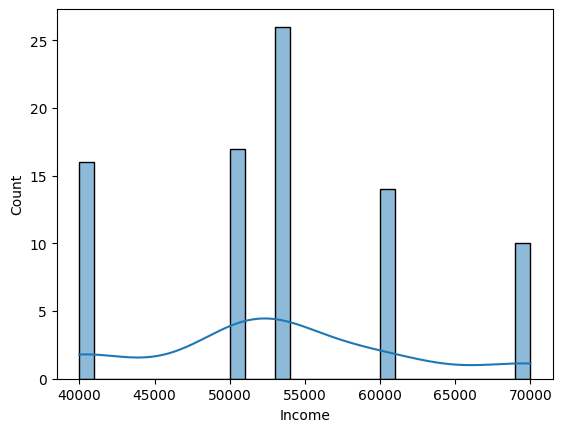

In [14]:
sns.histplot(messy_dataset_original['Income'], bins=30, kde=True)

Step 5 

In [15]:
print(messy_dataset_original.LastPurchaseDate.value_counts())
#data types
print(messy_dataset_original.LastPurchaseDate.dtypes)
#accidently ran after changing so it says datetime here, it was originally objects

LastPurchaseDate
2021-13-40    32
7/15/2021     27
5/20/2021     20
Name: count, dtype: int64
object


Since we see they are stored as strings, we can convert to date time format

In [16]:
messy_dataset_original.LastPurchaseDate = pd.to_datetime(messy_dataset_original.LastPurchaseDate, errors='coerce')
messy_dataset_original.LastPurchaseDate.value_counts()

/var/folders/56/3c156ggn00d8wr2q856gw0140000gn/T/ipykernel_10872/2396841730.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  messy_dataset_original.LastPurchaseDate = pd.to_datetime(messy_dataset_original.LastPurchaseDate, errors='coerce')


LastPurchaseDate
2021-07-15    27
2021-05-20    20
Name: count, dtype: int64

In [17]:
print(messy_dataset_original.LastPurchaseDate.isna().value_counts())

LastPurchaseDate
True     53
False    47
Name: count, dtype: int64


Step 6

In [18]:
messy_dataset_original.Review.value_counts()

Review
Loved it!!!            15
Great product!         13
would buy again        13
terrible service...    12
Ok                     12
Horrible!!             12
Name: count, dtype: int64

In [24]:
#Creating binary values, saving as final dataset
cleaned_dataset = messy_dataset_original.assign(PositiveReview = messy_dataset_original.Review.str.contains('great|love|buy again', case=False, na=False).astype(int))

We can see the results here

In [25]:
cleaned_dataset[['Review', 'PositiveReview']].head(15)

,Review,PositiveReview
0,NaN,0
1,NaN,0
2,NaN,0
3,Great product!,1
4,Loved it!!!,1
5,terrible service...,0
6,Ok,0
7,NaN,0
8,Loved it!!!,1
9,terrible service...,0


In [27]:
print("My favorite food is chicken, rice, and guacamole with honey barbecue sauce")

My favorite food is chicken, rice, and guacamole with honey barbecue sauce


In [26]:
#Final Dataframe
cleaned_dataset

,CustomerID,Age,State,Income,Purchases,LastPurchaseDate,Review,Churn,PositiveReview
0,CUST001,40.0,California,40000.0,0.0,NaT,NaN,NaN,0
1,CUST002,40.0,California,40000.0,1.0,NaT,NaN,NaN,0
2,CUST003,60.0,New York,40000.0,10.0,NaT,NaN,No,0
3,CUST004,57.0,California,53158.0,10.0,NaT,Great product!,Yes,1
4,CUST005,57.0,California,40000.0,NaN,2021-05-20,Loved it!!!,Yes,1
...,...,...,...,...,...,...,...,...,...
95,CUST096,30.0,California,70000.0,10.0,NaT,Ok,No,0
96,CUST097,25.0,California,50000.0,NaN,NaT,would buy again,NaN,1
97,CUST098,25.0,NaN,53158.0,1.0,NaT,Great product!,No,1
98,CUST099,25.0,California,50000.0,3.0,NaT,Great product!,Yes,1
